In [109]:
import numpy as np
import scipy
import csv
import matplotlib.pyplot as plt
from py3gpp import *

In [110]:
input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST_10MS.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY2.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPOTIFY.csv'
# input_file = '/home/chatchamon/workarea/IQ_constellation/iq_python/input/IQDataFile_SPEEDTEST.csv'

with open(input_file, 'r') as f:
    reader = csv.reader(f)
    for _ in range(19):
        next(reader)

    iq_val = []
    for row in reader:
        i_val = float(row[0])
        q_val = float(row[1])
        iq_val.append(complex(i_val,q_val))     # I+jQ

    waveform_csv = np.array(iq_val[:230401])    # 10 ms
    # waveform_csv = np.array(iq_val[230401:])

print('len_waveform_csv', len(waveform_csv), 'waveform_csv', waveform_csv)

len_waveform_csv 230401 waveform_csv [-0.00123117-0.00102036j  0.00109794-0.00055222j  0.00108245-0.00025547j
 ... -0.00217325+0.00065244j -0.00204915-0.00105801j
 -0.00108961-0.00154664j]


In [111]:
# downsampling, low pass filter
dec_factor = 8
waveform = scipy.signal.decimate(waveform_csv, dec_factor, ftype='fir')
# print("waveform after decimate:",waveform[:5])

# scale up max amplitude to 1
waveform /= max(waveform.real.max(), waveform.imag.max())
# print("waveform scale max amplitude to 1:",waveform[:5])
print('len_waveform', len(waveform), 'waveform', waveform)

sampleRate = 23.04e6
sampleRateDS = sampleRate // dec_factor     # floor devision, sampleRate down sample  

len_waveform 28801 waveform [ 0.16179951-0.23512766j  0.19998263-0.167384j   -0.05051995+0.30468921j
 ...  0.40895248-0.09217698j -0.41135963-0.26136865j
 -0.27107295-0.12754564j]


In [112]:
# add SNR to the waveform
# SC polar decoder can decode this when repeated bits in nrRateMatchPolar() are used
np.random.seed(69)
noise = ((np.random.rand(waveform.shape[0]) - 0.5) + 1j*(np.random.rand(waveform.shape[0]) - 0.5)) * 0.8
SNR = 10*np.log10((np.linalg.norm(waveform) / np.linalg.norm(noise)))
waveform += noise
print(f'SNR = {SNR} dB')

SNR = -1.774563669688518 dB


In [113]:
nrbSSB = 20
scsSSB = 30
searchBW = 6*scsSSB
# searchBW = 12*scsSSB


# shift by half scs step
fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/2
# fshifts = np.arange(-searchBW, searchBW+scsSSB, scsSSB)*1e3/5
print('len_fshifts', len(fshifts), 'fshifts:', fshifts)

t = np.arange(len(waveform))/sampleRateDS
# print('len_t', len(t),'t',t)

len_fshifts 13 fshifts: [-90000. -75000. -60000. -45000. -30000. -15000.      0.  15000.  30000.
  45000.  60000.  75000.  90000.]


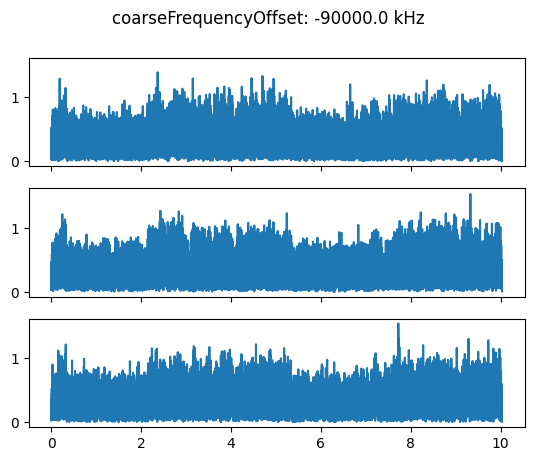

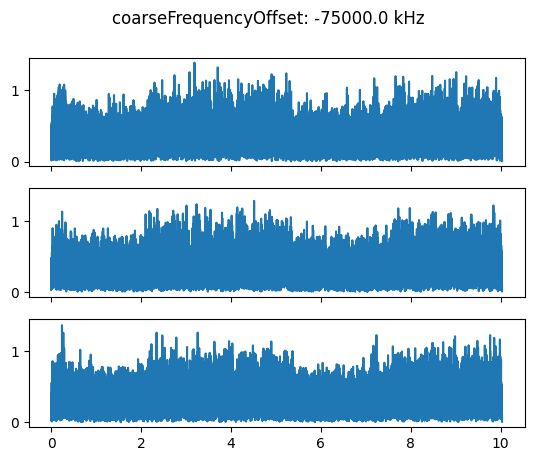

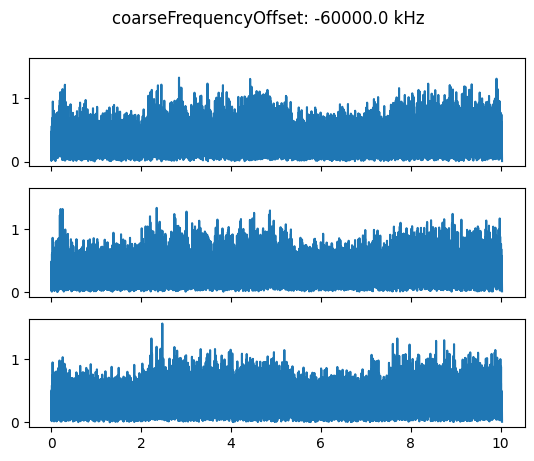

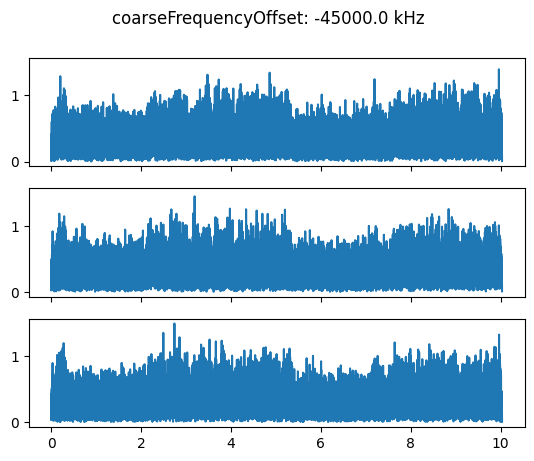

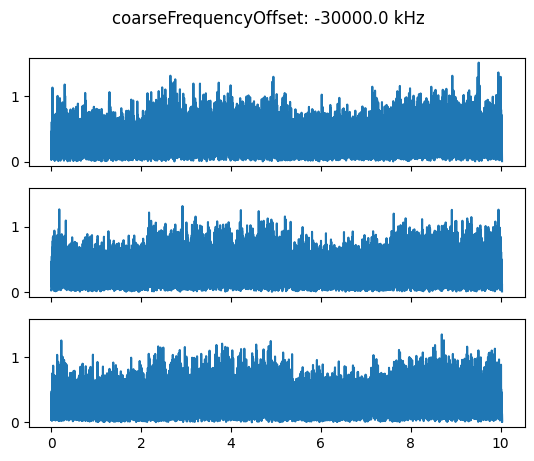

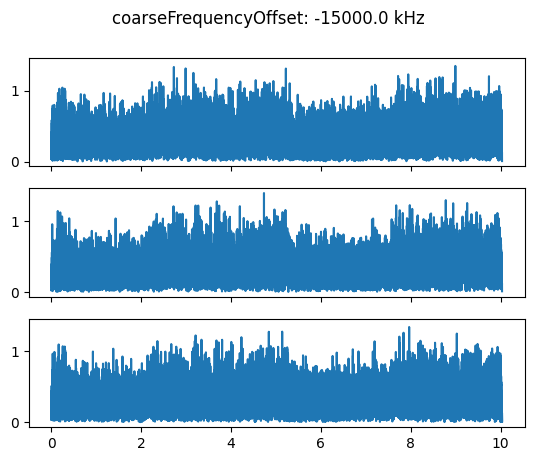

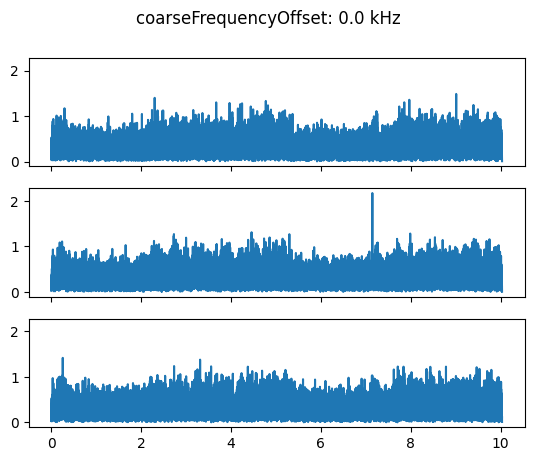

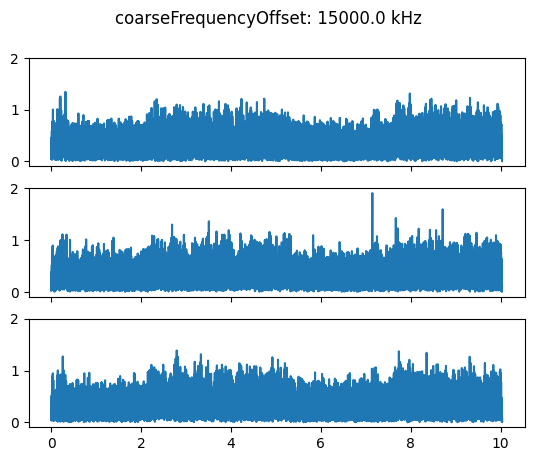

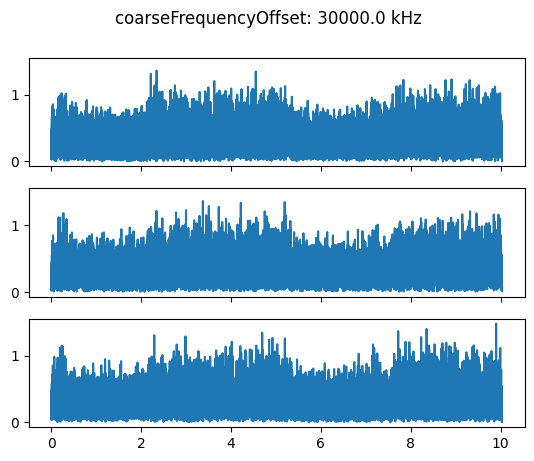

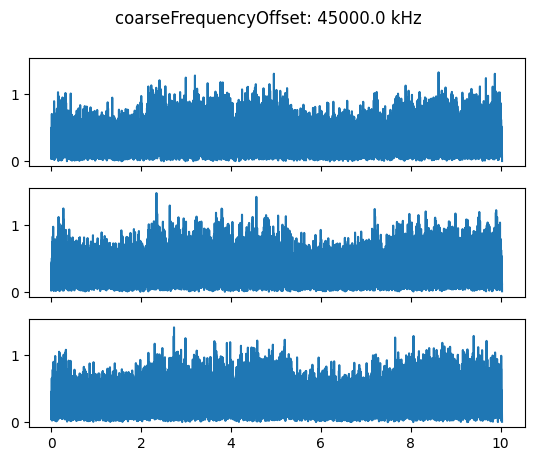

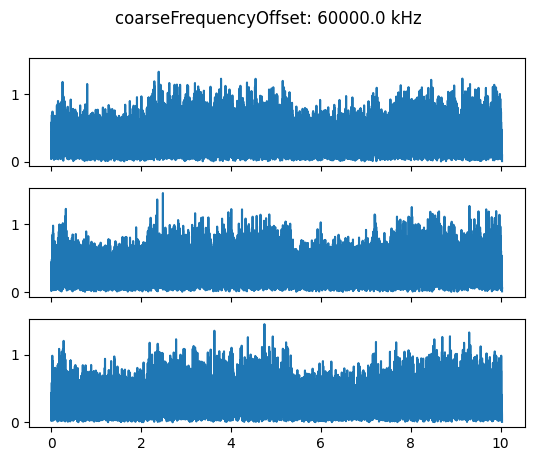

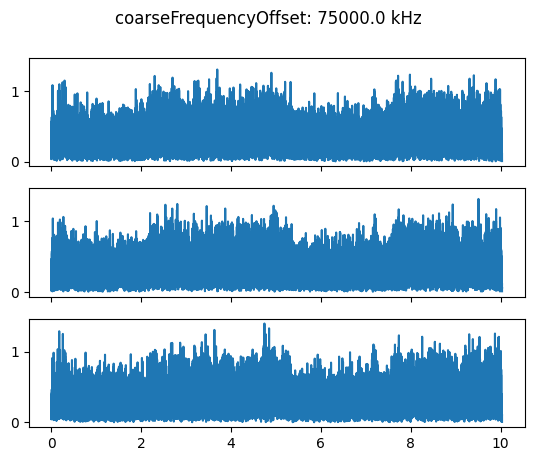

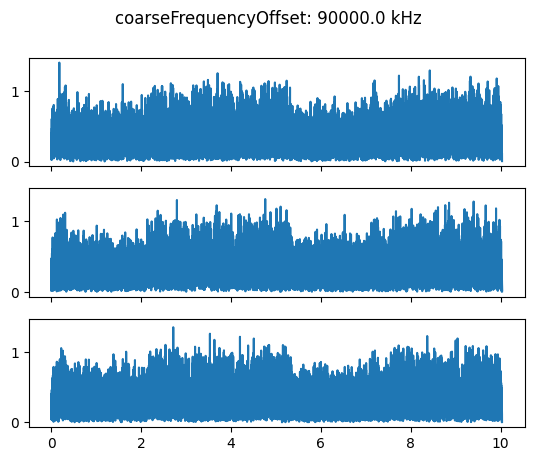

In [114]:
# it will always be the same, no need to stay in the loop
carrier = nrCarrierConfig(NSizeGrid = nrbSSB, SubcarrierSpacing = scsSSB)
info = nrOFDMInfo(carrier)
Nfft = info['Nfft']         # scs = 30kHz, Nfft = 512

kPSS = np.arange(56, 183)

peak_value = np.zeros((len(fshifts),3))
peak_index = np.zeros((len(fshifts),3), 'int')

# loop on fshifts
for fshifts_index in np.arange(len(fshifts), dtype='int'):
    coarseFrequencyOffset = fshifts[fshifts_index]
    # print('coarseFrequencyOffset:', coarseFrequencyOffset)

    # shift frequency by coarseFrequencyOffset
    rxWaveformFrquencyShift = waveform*np.exp(-1j*2*np.pi*coarseFrequencyOffset*t)
    nSlot = 0
    T = len(rxWaveformFrquencyShift)

    slotGrid = nrResourceGrid(carrier)
    slotGrid = slotGrid[:,1]

    # loop on NID2
    fig, axs = plt.subplots(3, 1, facecolor='w', sharex=True, sharey=True)
    fig.suptitle(f"coarseFrequencyOffset: {coarseFrequencyOffset} kHz")
    for current_NID2 in np.arange(3, dtype='int'):
        # current_NID2 = 1
        slotGrid[kPSS] = nrPSS(current_NID2)        # at slot index KPSS assign value nrPSS(current_NID2)
        # generate refWaveform by modulate signal on carrier and slotGrid with assigned nrPSS
        [refWaveform, info] = nrOFDMModulate(carrier, slotGrid, scsSSB, nSlot, Nfft, SampleRate=sampleRateDS)
        refWaveform = refWaveform[info['CyclicPrefixLengths'][0]:]; # remove CP

        # cross correlate waveform with refWaveform
        temp = scipy.signal.correlate(rxWaveformFrquencyShift, refWaveform)
        t_corr = np.arange(temp.shape[0])/sampleRateDS*1e3

        # record magnitude 
        peak_index[fshifts_index, current_NID2] = np.argmax(np.abs(temp))
        peak_value[fshifts_index, current_NID2] = np.abs(temp[peak_index[fshifts_index, current_NID2]])

        # plot result, number of display figure = len(fshifts)s
        axs[current_NID2].plot(t_corr, np.abs(temp))

# print(peak_index)
# print(peak_value)

In [115]:
max_corr = np.max(peak_value)
select_row = np.floor(np.argmax(peak_value) // 3)   
coarseFrequencyOffset = fshifts[select_row]    
NID2 = np.argmax(peak_value[select_row,:])

print("max_corr", max_corr)
print("coarseFrequencyOffset", coarseFrequencyOffset, "NID2", NID2)

if max_corr < 1.8:                  # choose the threshold randomly
    print("too low correlation")

print(peak_value)

max_corr 2.174395467816454
coarseFrequencyOffset 0.0 NID2 1
[[1.39084052 1.52708598 1.5414219 ]
 [1.38913109 1.28000809 1.36602785]
 [1.32566556 1.32894387 1.5629848 ]
 [1.39434469 1.44586857 1.49519791]
 [1.51034549 1.31197134 1.34411367]
 [1.34760863 1.39422176 1.34512071]
 [1.48551969 2.17439547 1.41920057]
 [1.34278406 1.9067229  1.38615524]
 [1.35994592 1.36084383 1.47973034]
 [1.32791522 1.47270716 1.41507837]
 [1.323636   1.45811535 1.44861539]
 [1.29924918 1.31361996 1.3963739 ]
 [1.39900756 1.31419296 1.34643652]]
